In [322]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)
np.random.seed(1)

## Data Overview

In [323]:
df = pd.read_csv("SpotifyFeatures.csv")
df = df.sample(df.shape[0])
print(df.shape)
df.head(5)

(232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
166804,Rock,David Bowie,Starman - 2012 Remastered Version,0pQskrTITgmCMyr85tb9qq,74,0.166000,0.486,254293,0.4500,0.000002,F,0.5400,-10.298,Major,0.0267,100.456,4/4,0.5500
187633,Ska,Panteon Rococo,Perdón,0DOlaVxCIgxFXhq4TFJBmr,29,0.226000,0.672,338267,0.4460,0.001490,C,0.1130,-14.094,Major,0.0471,111.574,4/4,0.7510
79839,Opera,Giacomo Puccini,"Puccini: La bohème, Act 1: ""Sì. Mi chiamano Mi...",4tHFwiwI62Wa6xgquB4t2G,17,0.987000,0.228,289107,0.0475,0.001230,D,0.1260,-18.715,Major,0.0457,90.908,3/4,0.0556
98763,Children’s Music,Hot Mulligan,How Do You Know It’s Not Armadillo Shells?,019CBVYnVKnSZVHNRnjqkx,48,0.035400,0.691,163509,0.6410,0.000034,C#,0.0989,-6.947,Major,0.0309,103.975,4/4,0.4220
188563,Ska,Strung Out,A War Called Home,4zuVHTYCBbS8SmTv5qsX9V,24,0.000037,0.330,200800,0.9890,0.247000,A,0.1540,-3.270,Major,0.1060,168.020,4/4,0.2830


In [324]:
df.isnull().any()

genre               False
artist_name         False
track_name          False
track_id            False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
dtype: bool

In [170]:
print(df["track_id"].shape)
print(df["track_id"].drop_duplicates().shape)

(232725,)
(176774,)


In [172]:
df = df.drop_duplicates("track_id")
print(df.shape)

(176774, 18)


/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


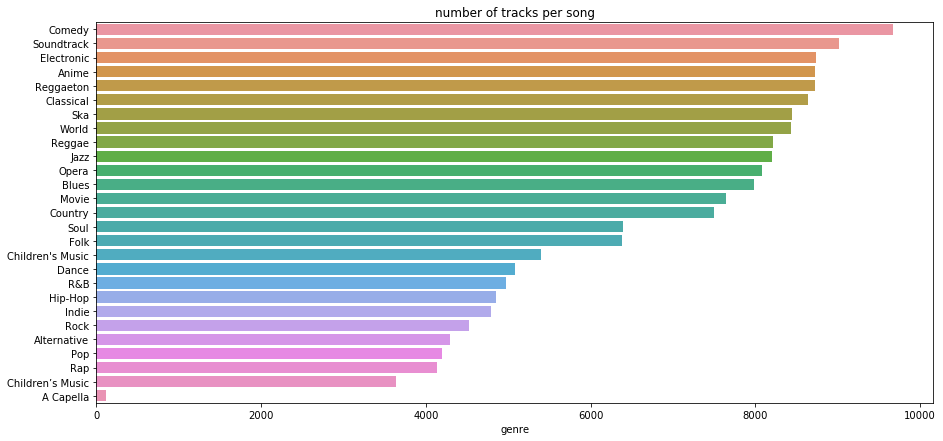

In [173]:
val_counts = df["genre"].value_counts()
x = val_counts
y = val_counts.index

figure = plt.figure(figsize = (15, 7))
plt.title("number of tracks per song")
sns.barplot(x, y)

In [174]:
columns = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "valence",
    "tempo",
    "key",
    "time_signature",
    "genre"
          ]

df_selected = df[columns][df["genre"] != "A Capella"]
df_selected.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key,time_signature,genre
166804,0.166000,0.486,0.4500,0.000002,0.5400,-10.298,0.0267,0.5500,100.456,F,4/4,Rock
187633,0.226000,0.672,0.4460,0.001490,0.1130,-14.094,0.0471,0.7510,111.574,C,4/4,Ska
79839,0.987000,0.228,0.0475,0.001230,0.1260,-18.715,0.0457,0.0556,90.908,D,3/4,Opera
98763,0.035400,0.691,0.6410,0.000034,0.0989,-6.947,0.0309,0.4220,103.975,C#,4/4,Children’s Music
188563,0.000037,0.330,0.9890,0.247000,0.1540,-3.270,0.1060,0.2830,168.020,A,4/4,Ska


## Label Keys

In [175]:
music_key = df_selected["key"].drop_duplicates()
df_key = pd.DataFrame(music_key)
df_key["label_key"] = np.arange(df_key.shape[0])
df_key = df_key.reset_index()[["key", "label_key"]]
print(df_key.shape)
df_key.head(10)

(12, 2)


,key,label_key
0,F,0
1,C,1
2,D,2
3,C#,3
4,A,4
5,D#,5
6,E,6
7,F#,7
8,G#,8
9,B,9


## Tabel time signature

In [176]:
time_sig = df_selected["time_signature"].drop_duplicates()
df_time = pd.DataFrame(time_sig)
df_time["time_sig_label"] = np.arange(df_time.shape[0])
df_time = df_time.reset_index()[["time_signature", "time_sig_label"]]
print(df_time.shape)
df_time.head(5)

(5, 2)


,time_signature,time_sig_label
0,4/4,0
1,3/4,1
2,1/4,2
3,5/4,3
4,0/4,4


## Label genre

In [177]:
genres = df_selected["genre"].drop_duplicates()
df_genres = pd.DataFrame(genres)
df_genres["label_genre"] = np.arange(df_genres.shape[0])
df_genres = df_genres.reset_index()[["genre", "label_genre"]]
print(df_genres.shape)
df_genres.head(5)

(26, 2)


,genre,label_genre
0,Rock,0
1,Ska,1
2,Opera,2
3,Children’s Music,3
4,Indie,4


In [178]:
df_cleaned = df_selected.merge(df_genres, how = "left", left_on = "genre", right_on = "genre")
df_cleaned = df_cleaned.merge(df_key, how = "left", left_on = "key", right_on = "key")
df_cleaned = df_cleaned.merge(df_time, how = "left", left_on = "time_signature", right_on = "time_signature")
print(df_cleaned.shape)
df_cleaned.head(5)

(176655, 15)


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key,time_signature,genre,label_genre,label_key,time_sig_label
0,0.166000,0.486,0.4500,0.000002,0.5400,-10.298,0.0267,0.5500,100.456,F,4/4,Rock,0,0,0
1,0.226000,0.672,0.4460,0.001490,0.1130,-14.094,0.0471,0.7510,111.574,C,4/4,Ska,1,1,0
2,0.987000,0.228,0.0475,0.001230,0.1260,-18.715,0.0457,0.0556,90.908,D,3/4,Opera,2,2,1
3,0.035400,0.691,0.6410,0.000034,0.0989,-6.947,0.0309,0.4220,103.975,C#,4/4,Children’s Music,3,3,0
4,0.000037,0.330,0.9890,0.247000,0.1540,-3.270,0.1060,0.2830,168.020,A,4/4,Ska,1,4,0


In [179]:
parameters = [
        "acousticness",
        "danceability",
        "energy",
        "instrumentalness",
        "liveness",
        "loudness",
        "speechiness",
        "valence",
            ]
X = np.asanyarray(df_cleaned[parameters])
y = np.asanyarray(df_cleaned["label_genre"])
print(X.shape, y.shape)
X[:5, :]

(176655, 8) (176655,)


array([[ 1.6600e-01,  4.8600e-01,  4.5000e-01,  2.0600e-06,  5.4000e-01,
        -1.0298e+01,  2.6700e-02,  5.5000e-01],
       [ 2.2600e-01,  6.7200e-01,  4.4600e-01,  1.4900e-03,  1.1300e-01,
        -1.4094e+01,  4.7100e-02,  7.5100e-01],
       [ 9.8700e-01,  2.2800e-01,  4.7500e-02,  1.2300e-03,  1.2600e-01,
        -1.8715e+01,  4.5700e-02,  5.5600e-02],
       [ 3.5400e-02,  6.9100e-01,  6.4100e-01,  3.3600e-05,  9.8900e-02,
        -6.9470e+00,  3.0900e-02,  4.2200e-01],
       [ 3.6800e-05,  3.3000e-01,  9.8900e-01,  2.4700e-01,  1.5400e-01,
        -3.2700e+00,  1.0600e-01,  2.8300e-01]])

In [180]:
total_labels = df_cleaned["genre"].drop_duplicates().shape[0]
total_labels

26

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("X train shape: ", X_train.shape, ", y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape, ", y test shape: ", y_test.shape)

X train shape:  (123658, 8) , y train shape:  (123658,)
X test shape:  (52997, 8) , y test shape:  (52997,)


In [182]:
X_train_tensor = torch.tensor(X_train).type(torch.FloatTensor)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test).type(torch.FloatTensor)
y_test_tensor = torch.tensor(y_test)

print("X train shape: ", X_train_tensor.shape, ", y train shape: ", y_train_tensor.shape)
print("X test shape: ", X_test_tensor.shape, ", y test shape: ", y_test_tensor.shape)

X train shape:  torch.Size([123658, 8]) , y train shape:  torch.Size([123658])
X test shape:  torch.Size([52997, 8]) , y test shape:  torch.Size([52997])


In [183]:
class train_data(Dataset):
    def __init__(self):
        self.x = X_train_tensor
        self.y = y_train_tensor
        self.len = X_train_tensor.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [184]:
class test_data(Dataset):
    def __init__(self):
        self.x = X_test_tensor
        self.y = y_test_tensor
        self.len = X_test_tensor.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [185]:
train_dataset = train_data()
validation_dataset = test_data()

In [186]:
trainloader = DataLoader(dataset = train_dataset, batch_size = 1000)
validation = DataLoader(dataset = validation_dataset, batch_size = 10000)

In [187]:
def accuracy(model, dataset):
    _, y_hat = torch.max(model(dataset.x), 1)
    return (y_hat == dataset.y).numpy().mean()

In [188]:
class NN_BatchNorm(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(NN_BatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
        self.bn = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.bn(torch.sigmoid(self.linear1(x)))
        x = self.linear2(x)
        return x

In [202]:
class NN_He(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(NN_He, self).__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        torch.nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity = 'relu')
        self.linear2 = nn.Linear(hidden_size, out_size)
        torch.nn.init.kaiming_uniform_(self.linear2.weight, nonlinearity = 'relu')
        self.bn = nn.BatchNorm1d(hidden_size)
        
    def forward(self, x):
        x = self.bn(torch.sigmoid(self.linear1(x)))
        x = self.linear2(x)
        return x

In [362]:
class NN_HeBN(nn.Module):
    def __init__(self, in_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, out_size):
        super(NN_HeBN, self).__init__()
        self.linear1 = nn.Linear(in_size, hidden_size1)
        torch.nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity = 'relu')
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        torch.nn.init.kaiming_uniform_(self.linear2.weight, nonlinearity = 'relu')
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        torch.nn.init.kaiming_uniform_(self.linear3.weight, nonlinearity = 'relu')
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        torch.nn.init.kaiming_uniform_(self.linear4.weight, nonlinearity = 'relu')
        self.linear5 = nn.Linear(hidden_size4, out_size)
        torch.nn.init.kaiming_uniform_(self.linear5.weight, nonlinearity = 'relu')
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.bn4 = nn.BatchNorm1d(hidden_size4)

    def forward(self, x):
        x = self.bn1(nn.functional.relu(self.linear1(x)))
        x = self.bn2(nn.functional.relu(self.linear2(x)))
        x = self.bn3(nn.functional.relu(self.linear3(x)))
        x = self.bn4(torch.sigmoid(self.linear4(x)))
        x = self.linear5(x)
        return x

In [365]:
def train(dataset, model, criterion, trainloader, validation, optimizer, epochs = 100):
    LOSS = []
    ACC = []
    percent = epochs // 10
    
    if epochs > 500:
        percent = epochs // 20
    
    for epoch in range(epochs):
        if epochs > 10 and (epoch + 1) % percent == 0:
            print("training... ", 100 * (epoch + 1) / epochs, "% completed")
        for x, y in trainloader:
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        cost = loss.item()
        LOSS.append(cost)
        
        correct = 0
        for x, y in validation:
            model.eval()
            y_hat = model(x)
            _, label = torch.max(y_hat, 1)
            correct += (label == y).sum().item()

        acc = 100 * (correct / len(validation_dataset))
        ACC.append(acc)
        if epochs > 10 and (epoch + 1) % percent == 0:
            print("cost: ", cost, ", accuracy: ", acc)
        
        
    results = {"Loss": LOSS, "Accuracy": ACC}
    fig, ax1 = plt.subplots()
    color = "tab:red"
    ax1.plot(LOSS, color = color)
    ax1.set_xlabel('epoch', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    
    plt.show()
    
    return results

In [161]:
lr = 0.0002
model_bn = NN_BatchNorm(
                    in_size = 9,
                    hidden_size = 150,
                    out_size = 26
                   )
optimizer = torch.optim.Adam(model_bn.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

training...  10.0 % completed
training...  20.0 % completed
training...  30.0 % completed
training...  40.0 % completed
training...  50.0 % completed
training...  60.0 % completed
training...  70.0 % completed
training...  80.0 % completed
training...  90.0 % completed
training...  100.0 % completed


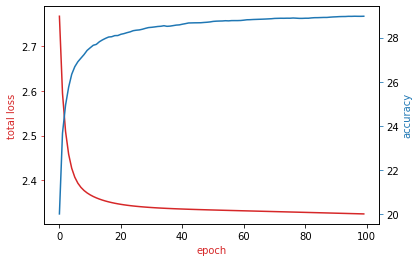

In [24]:
Results_BN = train(train_dataset, model_bn, criterion, trainloader, validation, optimizer, epochs = 100)

In [203]:
lr = 0.0002
model_he = NN_He(
            in_size = 8,
            hidden_size = 150,
            out_size = 26
                )
optimizer = torch.optim.Adam(model_he.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

training...  10.0 % completed
cost:  2.273193120956421 , accuracy:  33.3490574938204
training...  20.0 % completed
cost:  2.252897262573242 , accuracy:  34.23778704454969
training...  30.0 % completed
cost:  2.245793104171753 , accuracy:  34.61516689623941
training...  40.0 % completed
cost:  2.2412829399108887 , accuracy:  34.81140441911806
training...  50.0 % completed
cost:  2.2375056743621826 , accuracy:  34.943487367209464
training...  60.0 % completed
cost:  2.2337584495544434 , accuracy:  35.062362020491726
training...  70.0 % completed
cost:  2.2298481464385986 , accuracy:  35.14161178934657
training...  80.0 % completed
cost:  2.22580885887146 , accuracy:  35.19633186784157
training...  90.0 % completed
cost:  2.2217636108398438 , accuracy:  35.25859954337038
training...  100.0 % completed
cost:  2.2178409099578857 , accuracy:  35.337849312225224


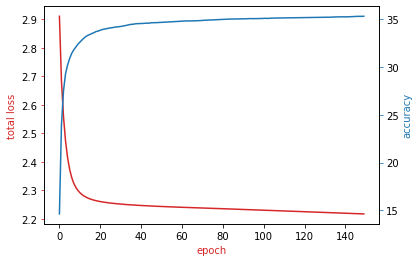

In [204]:
Results_He = train(train_dataset, model_he, criterion, trainloader, validation, optimizer, epochs = 150)

In [211]:
lr = 0.0002
model_HeBN = NN_HeBN(
            in_size = 8,
            hidden_size1 = 1000,
            hidden_size2 = 500,
            hidden_size3 = 250,
            hidden_size4 = 100,
            out_size = 26
                )
optimizer = torch.optim.Adam(model_HeBN.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

training...  10.0 % completed
cost:  2.1812028884887695 , accuracy:  35.885050097175316
training...  20.0 % completed
cost:  2.130892515182495 , accuracy:  36.28129894144951
training...  30.0 % completed
cost:  2.0983517169952393 , accuracy:  36.579429024284394
training...  40.0 % completed
cost:  2.070465564727783 , accuracy:  36.703964375342004
training...  50.0 % completed
cost:  2.0479061603546143 , accuracy:  36.62471460648716
training...  60.0 % completed
cost:  2.0293967723846436 , accuracy:  36.51527444949714
training...  70.0 % completed
cost:  2.010854959487915 , accuracy:  36.59452421835198
training...  80.0 % completed
cost:  1.9948270320892334 , accuracy:  36.54169103911542
training...  90.0 % completed
cost:  1.981444239616394 , accuracy:  36.66056569239768
training...  100.0 % completed
cost:  1.970295786857605 , accuracy:  36.681321584240614


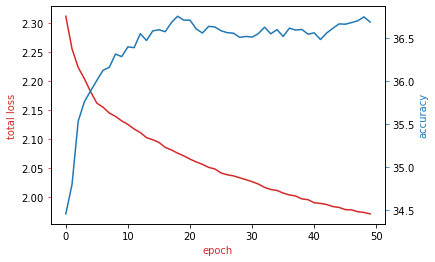

In [212]:
Results_HeBN = train(train_dataset, model_HeBN, criterion, trainloader, validation, optimizer, epochs = 50)